In [1]:
%matplotlib inline

import tkinter
import matplotlib
import platform
if platform.system() not in ['Linux', 'Darwin'] and not platform.system().startswith('CYGWIN'):
    matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'font.size': 8})

# 活化函數大清點 (pytorch)

In [2]:
import gc
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
import trident as T
from trident import *
from trident.layers.pytorch_activations import __all__

Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: bgr.
Pytorch version:1.2.0+cu92.
Pillow version:6.2.1.
Using pillow image backend.


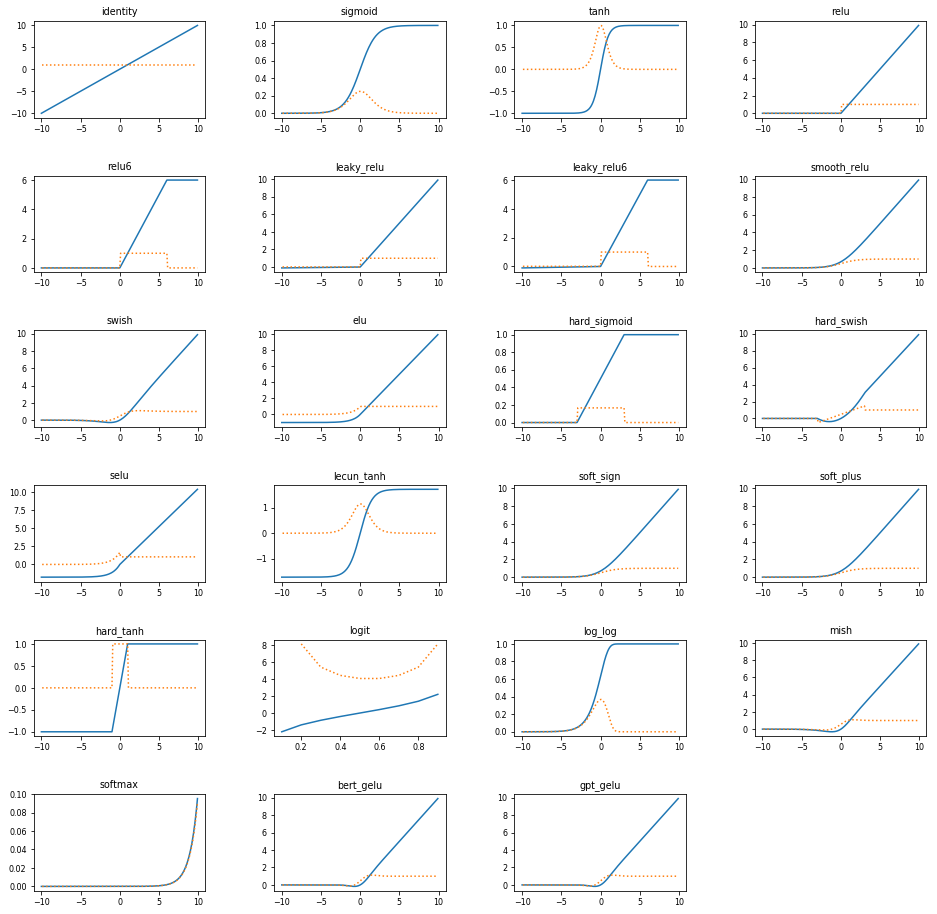

In [3]:
fig=plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
n=1
items= __all__[int( len(__all__)//2):-1]
plt.clf()
for k in  items :
    if k not in ('p_relu','prelu'):
        try:
            act_fn=get_activation(k)
            x =np.arange(-10, 10, 0.1).astype(np.float32)
            tensor_x=to_tensor(x)
            y=to_numpy(act_fn(tensor_x))
            ax1 = fig.add_subplot(6, 4, n)
            ax1.plot(x,y)
            ax1.plot(x[1:], np.diff(y) /(np.diff(x)+1e-8),ls=':')
            ax1.set_title(k)
            
        except Exception as e:
            print(e)
            pass
        n+=1
display.display(fig)

In [4]:
dataset=T.load_mnist('mnist','train',is_flatten=True)
dataset.image_transform_funcs=[normalize(127.5,127.5)]       


archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping data  in train scenario  success, total 60000 record addeds.
Mapping label  in train scenario  success, total 60000 records added.
Mapping class_names  in en-US   success, total 10 class names added.


archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping data  in train scenario  success, total 60000 record addeds.
Mapping label  in train scenario  success, total 60000 records added.
Mapping class_names  in en-US   success, total 10 class names added.
(64, 784)


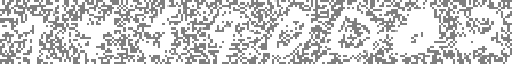

In [5]:
noise_dataset=T.load_mnist('mnist','train',is_flatten=True)
noise_dataset.image_transform_funcs=[normalize(127.5,127.5),add_noise(intensity=0.3)]       
noise_dataset.minibatch_size=64

im,label=noise_dataset.__next__()
print(im.shape)
im=array2image(np.concatenate(np.reshape(im[:8,:]*127.5+127.5,(8,28,28)).tolist(),1)).resize((64*8,64))
im

In [6]:
activations=['relu','sigmoid','tanh','selu','swish','mish']
def test_activity_function(act):
    #清掉記憶體垃圾以避免影響效能
    gc.collect()
    act_func=get_activation(act)
    print(act)
    
    #計算跑 10 萬次的總時間
    data =to_tensor(np.random.standard_normal((100000,1))) 
    start = time.time()
    results=[act_func(data[i]) for  i  in range(100000)]
    sec = time.time() - start
    print('{0:.6f} sec'.format(sec))

    #建 mnist模
    net=Sequential(
    Dense(64,use_bias=False,activation=act),
    Dense(10,use_bias=False,activation='softmax'))
    net.input_shape=[28*28]

    #為了避免 Adam自適應調整對測試的影響，這裡使用SGD 
    plan=TrainingPlan()\
    .add_training_item(
    TrainingItem(model=net,optimizer='SGD',lr=1e-3,weight_decay=1e-5).with_loss(CrossEntropyLoss).with_metrics(accuracy))\
    .with_data_loader(dataset)\
    .within_minibatch_size(128)\
    .print_progress_scheduling(100,unit='batch')\

    #讓他跑1000 次，過程中的權重變化與梯度變化都保留
    plan.only_steps(num_steps=1000,keep_weights_history=True,keep_gradient_history=True,keep_target_history=False )
    #計算效度指標
    print('最低 loss {0:.4e}  最佳 metrics {1:.4%}  最後10次 metrics {2:.4%}'.format(min(plan.training_items[0].batch_loss_history['total_losses']),\
                                                                              max(plan.training_items[0].batch_metric_history['accuracy']) ,\
                                                                              np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))

    # 分別使用乾淨數據與噪聲數據進行推論
    net.eval()
    accuracys=[]
    for i in range(100):
        input,target=dataset.__next__()
        input,target=to_tensor(input),to_tensor(target)
        accuracys.append(to_numpy(accuracy(net(input),target)))
    accuracys=np.asarray(accuracys)
        
    print('正常樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(accuracys.mean(),accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))

    
    noise_accuracys=[]
    for i in range(100):
        input,target=noise_dataset.__next__()
        input,target=to_tensor(input),to_tensor(target)
        noise_accuracys.append(to_numpy(accuracy(net(input),target)))
    noise_accuracys=np.asarray(noise_accuracys)
        
    print('噪聲樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(noise_accuracys.mean(),noise_accuracys.mean()-np.array(plan.training_items[0].batch_metric_history['accuracy'][-10:]).mean()))

    #繪製梯度與權重分布
    weights_history=plan.training_items[0].weights_history
    gradients_history=plan.training_items[0].gradients_history
    grads=[]
    weights=[]
    for i in range(len(gradients_history)):
        grads.append(gradients_history[i]['0.weight'].reshape([-1]))

    for i in range(len(weights_history)):
         weights.append(weights_history[i]['0.weight'].reshape([-1]))

    grads=np.asarray(grads)
    weights=np.asarray(weights)
    #計算梯度為零比例
    print('梯度為零比例 : {0:.3%}'.format(np.equal(grads,0).astype(np.float32).mean()))

    steps_histogram(grads,weights,inteval=50,imshow=True)
    

relu
14.407953 sec
  Step: 32s41ms  | Tot: 0ms      | Loss: 2.375   | Accuracy: 8.594%   | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 1s459ms  | Tot: 1s459ms  | Loss: 2.233   | Accuracy: 22.656%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 1s756ms  | Tot: 3s216ms  | Loss: 2.249   | Accuracy: 21.094%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 1s525ms  | Tot: 4s741ms  | Loss: 2.265   | Accuracy: 19.531%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 1s361ms  | Tot: 6s102ms  | Loss: 2.234   | Accuracy: 22.656%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 1s801ms  | Tot: 7s904ms  | Loss: 2.138   | Accuracy: 32.031%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 1s669ms  | Tot: 9s574ms  | Loss: 2.099   | Accuracy: 35.938%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 1s120ms  | Tot: 10s695ms | Loss: 2.101   | Accuracy: 35.938%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 1s153ms

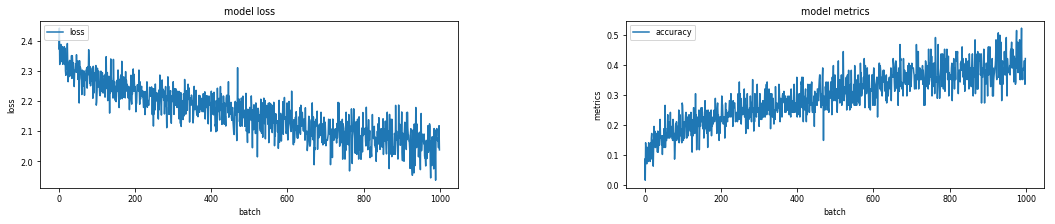

最低 loss 1.9372e+00  最佳 metrics 52.3438%  最後10次 metrics 38.5156%
正常樣本 accuracy 39.7422%  DIFF: 1.2266% 
噪聲樣本 accuracy 32.6562%  DIFF: -5.8594% 
梯度為零比例 : 42.158%


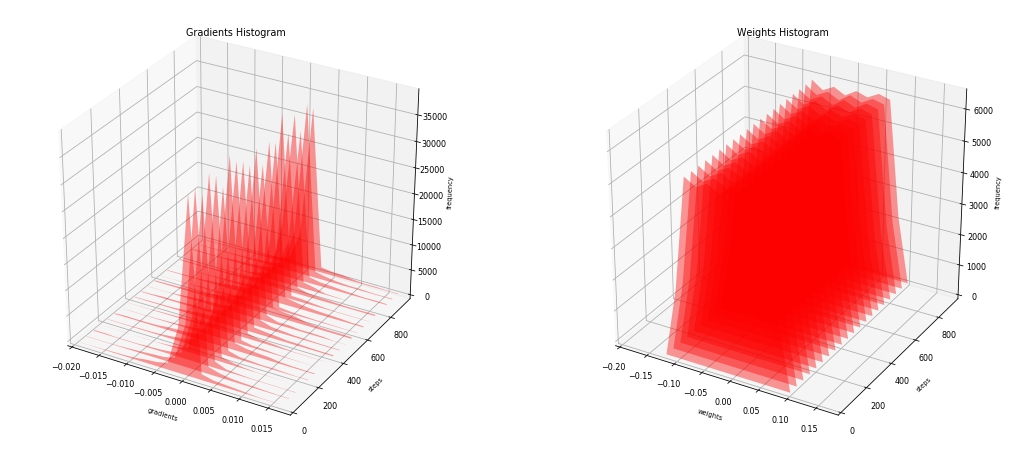

In [7]:
test_activity_function('relu')

leaky_relu
10.068033 sec
  Step: 18s952ms | Tot: 0ms      | Loss: 2.353   | Accuracy: 10.156%  | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 1s173ms  | Tot: 1s173ms  | Loss: 2.211   | Accuracy: 25.000%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 1s205ms  | Tot: 2s379ms  | Loss: 2.250   | Accuracy: 21.094%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 1s166ms  | Tot: 3s545ms  | Loss: 2.186   | Accuracy: 27.344%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 1s131ms  | Tot: 4s677ms  | Loss: 2.171   | Accuracy: 28.906%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 1s199ms  | Tot: 5s877ms  | Loss: 2.087   | Accuracy: 37.500%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 1s345ms  | Tot: 7s222ms  | Loss: 2.025   | Accuracy: 43.750%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 1s154ms  | Tot: 8s377ms  | Loss: 2.101   | Accuracy: 35.938%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 1

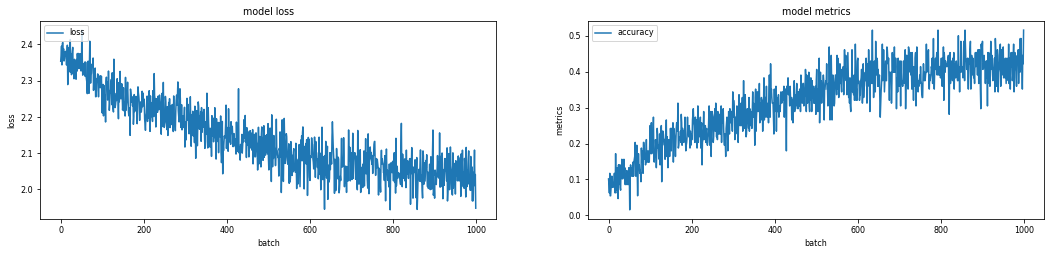

最低 loss 1.9440e+00  最佳 metrics 51.5625%  最後10次 metrics 43.5156%
正常樣本 accuracy 44.0547%  DIFF: 0.5391% 
噪聲樣本 accuracy 36.4219%  DIFF: -7.0938% 
梯度為零比例 : 34.641%


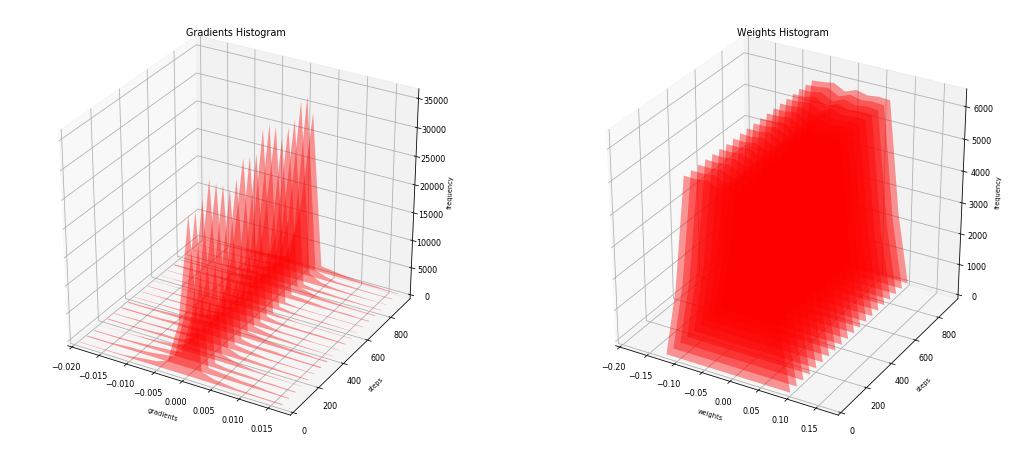

In [8]:
test_activity_function('leaky_relu')

sigmoid
11.533339 sec
  Step: 18s791ms | Tot: 0ms      | Loss: 2.295   | Accuracy: 12.500%  | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 1s248ms  | Tot: 1s248ms  | Loss: 2.288   | Accuracy: 12.500%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 1s520ms  | Tot: 2s769ms  | Loss: 2.295   | Accuracy: 14.844%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 1s619ms  | Tot: 4s388ms  | Loss: 2.308   | Accuracy: 10.938%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 1s284ms  | Tot: 5s672ms  | Loss: 2.287   | Accuracy: 13.281%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 1s159ms  | Tot: 6s831ms  | Loss: 2.269   | Accuracy: 20.312%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 1s158ms  | Tot: 7s990ms  | Loss: 2.283   | Accuracy: 14.844%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 1s175ms  | Tot: 9s165ms  | Loss: 2.271   | Accuracy: 16.406%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 1s17

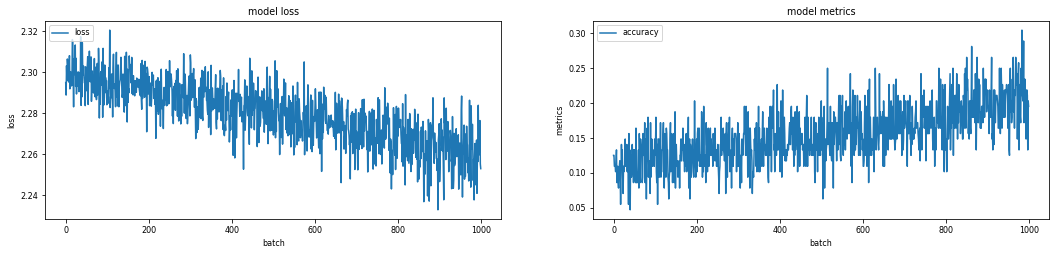

最低 loss 2.2329e+00  最佳 metrics 30.4688%  最後10次 metrics 19.6875%
正常樣本 accuracy 21.5078%  DIFF: 1.8203% 
噪聲樣本 accuracy 17.4531%  DIFF: -2.2344% 
梯度為零比例 : 42.770%


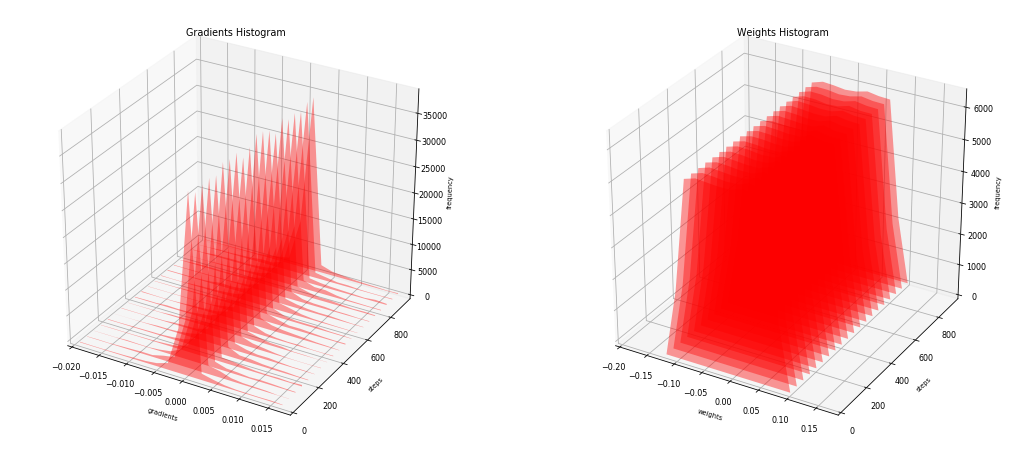

In [9]:
test_activity_function('sigmoid')

tanh
12.841634 sec
  Step: 20s157ms | Tot: 0ms      | Loss: 2.326   | Accuracy: 6.250%   | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 1s87ms   | Tot: 1s87ms   | Loss: 2.308   | Accuracy: 12.500%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 935ms    | Tot: 2s22ms   | Loss: 2.307   | Accuracy: 10.156%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 887ms    | Tot: 2s910ms  | Loss: 2.269   | Accuracy: 15.625%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 1s840ms  | Tot: 4s751ms  | Loss: 2.245   | Accuracy: 22.656%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 1s491ms  | Tot: 6s243ms  | Loss: 2.213   | Accuracy: 29.688%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 1s33ms   | Tot: 7s276ms  | Loss: 2.190   | Accuracy: 33.594%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 1s775ms  | Tot: 9s52ms   | Loss: 2.161   | Accuracy: 36.719%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 1s195ms

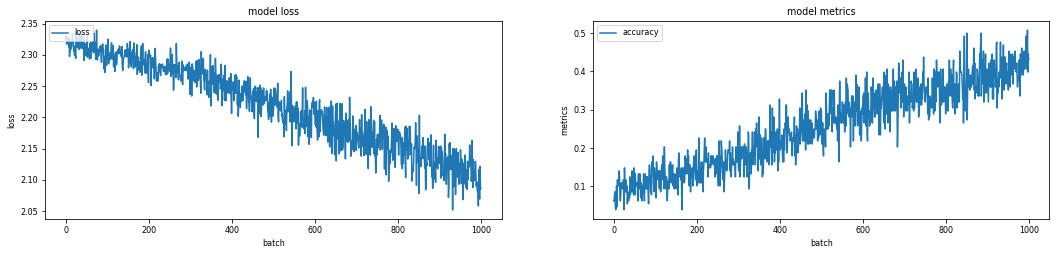

最低 loss 2.0521e+00  最佳 metrics 50.7812%  最後10次 metrics 44.5312%
正常樣本 accuracy 41.2344%  DIFF: -3.2969% 
噪聲樣本 accuracy 31.8906%  DIFF: -12.6406% 
梯度為零比例 : 55.957%


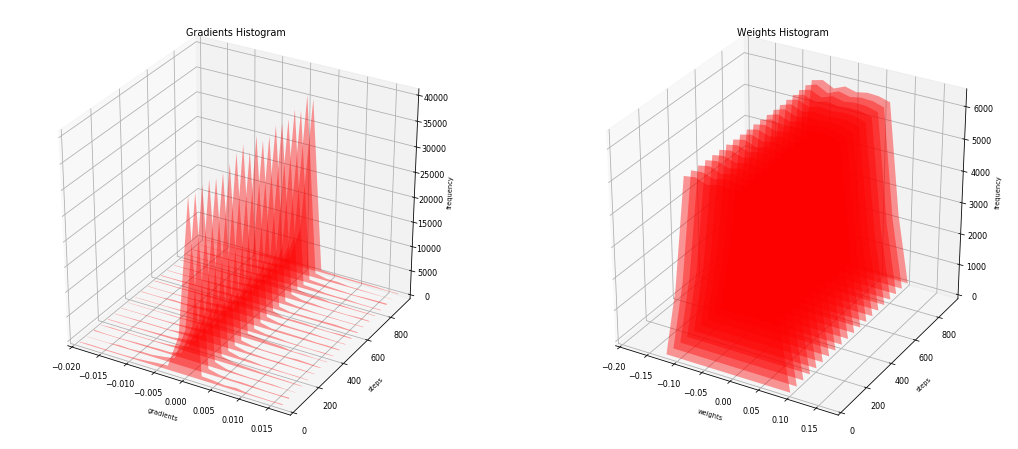

In [10]:
test_activity_function('tanh')

selu
12.246212 sec
  Step: 17s644ms | Tot: 0ms      | Loss: 2.316   | Accuracy: 14.844%  | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 1s206ms  | Tot: 1s206ms  | Loss: 2.218   | Accuracy: 24.219%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 2s42ms   | Tot: 3s248ms  | Loss: 2.201   | Accuracy: 25.781%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 2s72ms   | Tot: 5s320ms  | Loss: 2.213   | Accuracy: 24.219%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 1s614ms  | Tot: 6s934ms  | Loss: 2.130   | Accuracy: 32.812%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 1s379ms  | Tot: 8s314ms  | Loss: 2.068   | Accuracy: 39.062%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 1s254ms  | Tot: 9s569ms  | Loss: 2.133   | Accuracy: 32.812%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 1s67ms   | Tot: 10s636ms | Loss: 2.024   | Accuracy: 43.750%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 1s532ms

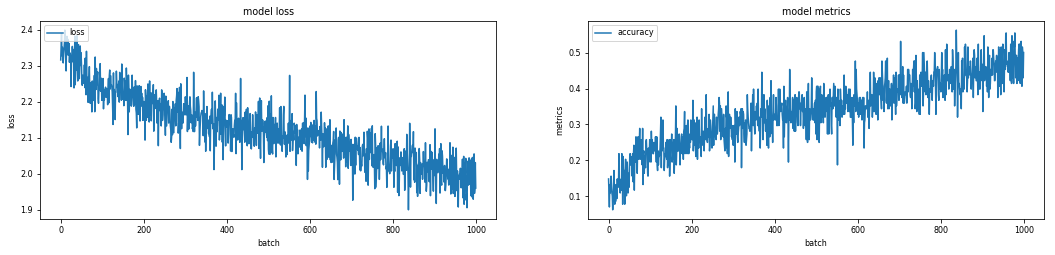

最低 loss 1.8999e+00  最佳 metrics 56.2500%  最後10次 metrics 47.9688%
正常樣本 accuracy 46.6406%  DIFF: -1.3281% 
噪聲樣本 accuracy 37.7187%  DIFF: -10.2500% 
梯度為零比例 : 41.406%


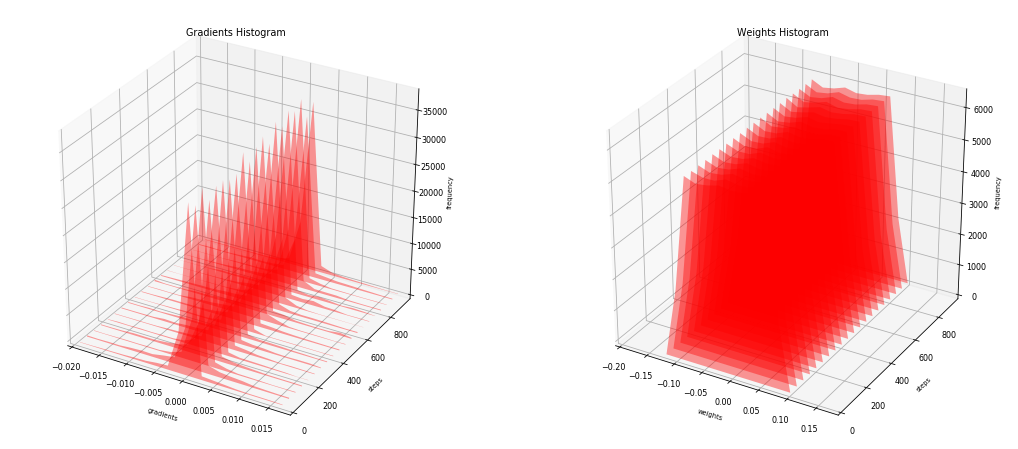

In [11]:
test_activity_function('selu')

swish
26.451345 sec
  Step: 35s816ms | Tot: 0ms      | Loss: 2.330   | Accuracy: 13.281%  | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 1s179ms  | Tot: 1s179ms  | Loss: 2.277   | Accuracy: 17.969%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 2s93ms   | Tot: 3s273ms  | Loss: 2.241   | Accuracy: 21.875%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 1s853ms  | Tot: 5s127ms  | Loss: 2.167   | Accuracy: 29.688%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 2s40ms   | Tot: 7s167ms  | Loss: 2.144   | Accuracy: 32.031%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 1s375ms  | Tot: 8s543ms  | Loss: 2.038   | Accuracy: 42.188%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 1s117ms  | Tot: 9s661ms  | Loss: 2.112   | Accuracy: 35.156%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 1s250ms  | Tot: 10s912ms | Loss: 2.038   | Accuracy: 42.188%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 1s154m

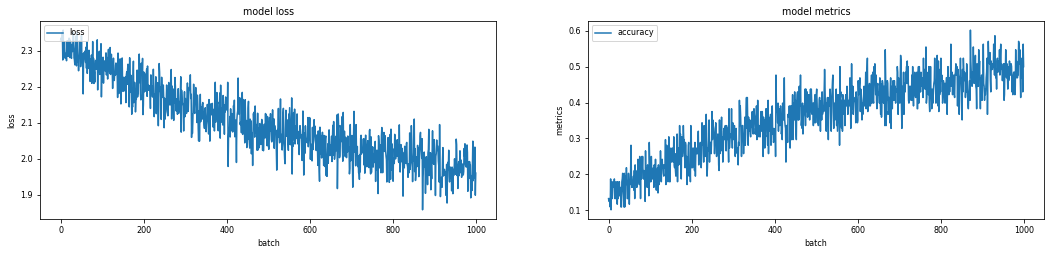

最低 loss 1.8575e+00  最佳 metrics 60.1562%  最後10次 metrics 49.1406%
正常樣本 accuracy 49.0859%  DIFF: -0.0547% 
噪聲樣本 accuracy 40.0469%  DIFF: -9.0938% 
梯度為零比例 : 38.251%


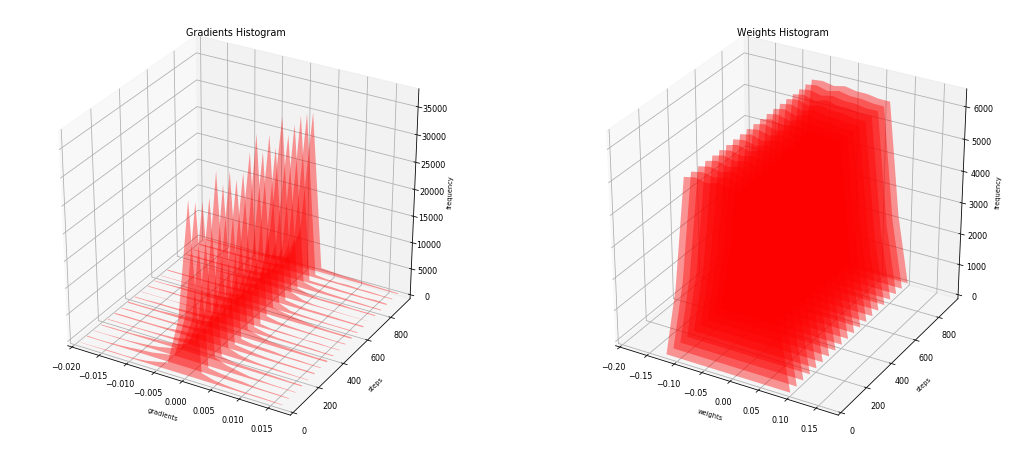

In [12]:
test_activity_function('swish')

mish
30.427979 sec
  Step: 37s851ms | Tot: 0ms      | Loss: 2.390   | Accuracy: 7.031%   | learning rate: 1.0000e-03| epoch: 1 ( 0/1000 )
  Step: 1s156ms  | Tot: 1s156ms  | Loss: 2.279   | Accuracy: 17.969%  | learning rate: 1.0000e-03| epoch: 1 ( 100/1000 )
  Step: 1s290ms  | Tot: 2s446ms  | Loss: 2.205   | Accuracy: 25.781%  | learning rate: 1.0000e-03| epoch: 1 ( 200/1000 )
  Step: 1s649ms  | Tot: 4s96ms   | Loss: 2.155   | Accuracy: 30.469%  | learning rate: 1.0000e-03| epoch: 1 ( 300/1000 )
  Step: 1s310ms  | Tot: 5s406ms  | Loss: 2.132   | Accuracy: 32.812%  | learning rate: 1.0000e-03| epoch: 1 ( 400/1000 )
  Step: 1s252ms  | Tot: 6s659ms  | Loss: 2.140   | Accuracy: 32.031%  | learning rate: 1.0000e-03| epoch: 1 ( 500/1000 )
  Step: 1s291ms  | Tot: 7s950ms  | Loss: 2.048   | Accuracy: 41.406%  | learning rate: 1.0000e-03| epoch: 1 ( 600/1000 )
  Step: 984ms    | Tot: 8s935ms  | Loss: 2.038   | Accuracy: 42.188%  | learning rate: 1.0000e-03| epoch: 1 ( 700/1000 )
  Step: 1s11ms 

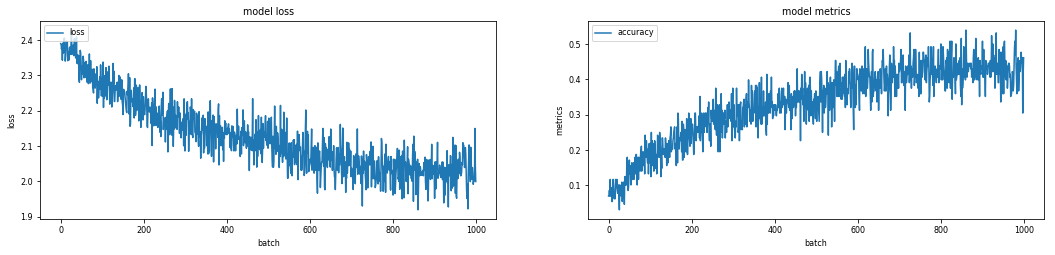

最低 loss 1.9191e+00  最佳 metrics 53.9062%  最後10次 metrics 43.2031%
正常樣本 accuracy 44.6562%  DIFF: 1.4531% 
噪聲樣本 accuracy 36.9844%  DIFF: -6.2187% 
梯度為零比例 : 40.073%


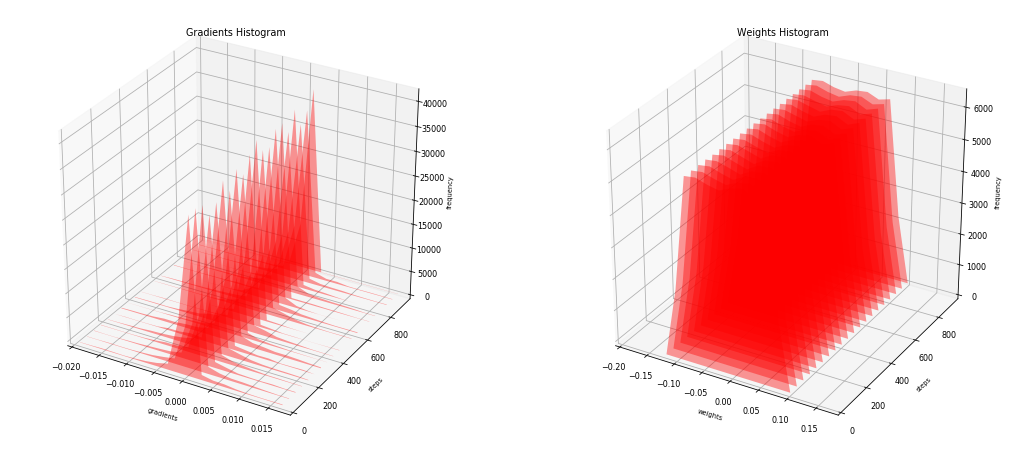

In [13]:
test_activity_function('mish')